<a href="https://colab.research.google.com/github/s-c-soma/AdvanceDeeplearning-CMPE-297/blob/master/Assignment_1_%20Part_2/Assignment1_part2_SemisupervisedLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semi Supervised Learning

# Implementation Details and Discussion

**Semi-supervised** is an machine learning approach that deals with both label and unlabeled data. The amount of labeled data is very less compared to unlabeled data. So Semi-supervised learning belongs to both unsupervised and supervised learning

**Implementation**

Semi supervised learning methods actually use the unlabeled data to modify or to change the priority of the data obtained from labeled data. Some methods are probabilistics also. We get a joint distribution for that.  Original discriminative methods can not be used here for semi supervised problems.


As mentioned above, semi supervised learning is a combination of supervised and unsupervised. So at first I loaded the Mnist. It is a labeled data. I have taken 20% of the labeled data. For the rest of the 80% data, I have removed the label and made it ready for unsupervised. Assigned label -1 for that. Finally I have defined the network, trained the model. This model performs with 92% accuracy. The last section visualizes the prediction of the model. 
 

# Using Mnist Data

In [43]:
from __future__ import print_function
import pickle 
import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from scipy import ndimage
from scipy import misc
import matplotlib.pyplot as plt
import tensorflow as tf
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import torchvision


## Parameters Definition 

In [44]:
n_epochs = 10
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

## Load Mnist

loading data and doing all the preprocessing stuffs here.

In [45]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

In [46]:
init_dataset =  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


val_dataset = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [47]:
len(init_dataset)


60000

## Spliting data for semi-supervised [20% labeled + 80% unlabeled]

Splitting the data to remove label for some data. Making the data prepared for semi supervised learning

In [48]:
lengths = [int(len(init_dataset)*0.2), int(len(init_dataset)*0.8)]
labeled_subsetA, unlabeled_subsetB = random_split(init_dataset, lengths)



train_unlabeled_data = [(unlabeled_subsetB[i][0],-1) for i in range(len(unlabeled_subsetB))]
len(train_unlabeled_data)

48000

In [49]:
def get_data_loaders(train_labeled_data, train_unlabeled_data, test_data, train_batch_size, val_batch_size):
    train_loader = DataLoader(train_labeled_data, batch_size=train_batch_size, shuffle=True)
    train_unlabeled_loader = DataLoader(train_unlabeled_data, batch_size=train_batch_size, shuffle=True)
    val_loader = DataLoader(test_data, batch_size=val_batch_size, shuffle=False,)



    return train_loader,train_unlabeled_loader, val_loader

In [50]:
batch_size_train = 64
batch_size_test = 1000

train_labeled_loader2,train_unlabeled_loader2,val_loader2 =  get_data_loaders(labeled_subsetA, train_unlabeled_data,val_dataset, batch_size_train, batch_size_test)

In [51]:
batch1 = next(iter(train_loader))
print(batch1[0].shape)
print(batch1[1].shape)
len(batch1)
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

torch.Size([64, 1, 28, 28])
torch.Size([64])


## Defing Network

Following code are to define a network to train the model for semi supervised learning

In [52]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [53]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [54]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(val_loader2.dataset) for i in range(n_epochs + 1)]

## Training

Training code is implemented below with 20 epochs

In [55]:
num_cycles = 20
# training
def train2(epoch=10):
    network.train()
    
    #pre-training without unlabeled data 
    if epoch > num_cycles:
        for batch_idx, (data, target) in enumerate(train_unlabeled_loader2):
            network.eval()
            output = network(data)
            fake_target = (output.data.max(1)[1].view(-1)) # using pseudo label method and get pseudo labels
            network.train()
            #data.volatile = False
            optimizer.zero_grad()
            output = network(data)
            loss = F.nll_loss(output, fake_target)
            loss.backward()
            optimizer.step()
            if batch_idx % 10 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_unlabeled_loader2.dataset),
                    100. * batch_idx / len(train_unlabeled_loader2), loss.item()))

    avg_train_loss = 0
    for batch_idx, (data, target) in enumerate(train_labeled_loader2):
        
        
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_labeled_loader2.dataset),
                100. * batch_idx / len(train_labeled_loader2), loss.item()))
            avg_train_loss += loss.item()
            train_losses.append(loss.item())
            train_counter.append(
              (batch_idx*64) + ((epoch-1)*len(train_labeled_loader2.dataset)))
     
    avg_train_loss = avg_train_loss / (len(train_labeled_loader2) / 500)
    #loss_compare.write(str(avg_train_loss) + ',') # no need for now



In [56]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in val_loader2: #modifing it : test_loader
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(val_loader2.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(val_loader2.dataset),
    100. * correct / len(val_loader2.dataset)))

## Network Training

In [57]:
#test()-- don't use this
for epoch in range(1, n_epochs + 1):
  train2(epoch)
  test()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/12000 (0%)]	Loss: 2.280108
Train Epoch: 1 [640/12000 (5%)]	Loss: 2.300120
Train Epoch: 1 [1280/12000 (11%)]	Loss: 2.315727
Train Epoch: 1 [1920/12000 (16%)]	Loss: 2.288256
Train Epoch: 1 [2560/12000 (21%)]	Loss: 2.262122
Train Epoch: 1 [3200/12000 (27%)]	Loss: 2.236043
Train Epoch: 1 [3840/12000 (32%)]	Loss: 2.240895
Train Epoch: 1 [4480/12000 (37%)]	Loss: 2.226709
Train Epoch: 1 [5120/12000 (43%)]	Loss: 2.216369
Train Epoch: 1 [5760/12000 (48%)]	Loss: 2.037981
Train Epoch: 1 [6400/12000 (53%)]	Loss: 2.044498
Train Epoch: 1 [7040/12000 (59%)]	Loss: 1.922124
Train Epoch: 1 [7680/12000 (64%)]	Loss: 1.860842
Train Epoch: 1 [8320/12000 (69%)]	Loss: 1.929248
Train Epoch: 1 [8960/12000 (74%)]	Loss: 1.859352
Train Epoch: 1 [9600/12000 (80%)]	Loss: 1.547276
Train Epoch: 1 [10240/12000 (85%)]	Loss: 1.469411
Train Epoch: 1 [10880/12000 (90%)]	Loss: 1.380514
Train Epoch: 1 [11520/12000 (96%)]	Loss: 1.304663


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.9194, Accuracy: 7702/10000 (77%)

Train Epoch: 2 [0/12000 (0%)]	Loss: 1.245226
Train Epoch: 2 [640/12000 (5%)]	Loss: 1.241017
Train Epoch: 2 [1280/12000 (11%)]	Loss: 1.429889
Train Epoch: 2 [1920/12000 (16%)]	Loss: 1.126313
Train Epoch: 2 [2560/12000 (21%)]	Loss: 1.247316
Train Epoch: 2 [3200/12000 (27%)]	Loss: 1.217231
Train Epoch: 2 [3840/12000 (32%)]	Loss: 1.258195
Train Epoch: 2 [4480/12000 (37%)]	Loss: 0.844204
Train Epoch: 2 [5120/12000 (43%)]	Loss: 1.103262
Train Epoch: 2 [5760/12000 (48%)]	Loss: 0.743715
Train Epoch: 2 [6400/12000 (53%)]	Loss: 1.010372
Train Epoch: 2 [7040/12000 (59%)]	Loss: 0.816469
Train Epoch: 2 [7680/12000 (64%)]	Loss: 0.943020
Train Epoch: 2 [8320/12000 (69%)]	Loss: 0.927767
Train Epoch: 2 [8960/12000 (74%)]	Loss: 0.783610
Train Epoch: 2 [9600/12000 (80%)]	Loss: 0.786202
Train Epoch: 2 [10240/12000 (85%)]	Loss: 0.744489
Train Epoch: 2 [10880/12000 (90%)]	Loss: 0.865050
Train Epoch: 2 [11520/12000 (96%)]	Loss: 0.735474

Test set: Avg

In [58]:
# fixing the shape issue
print(n_epochs)
len(test_losses)

len(test_counter)

10


11

In [59]:
with torch.no_grad():
  output = network(example_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


## Visualizing Accuracy and Prediction

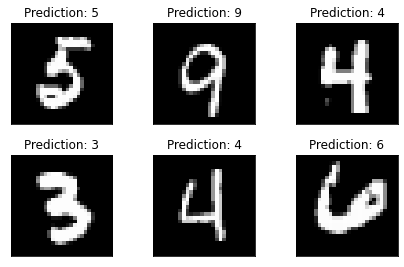

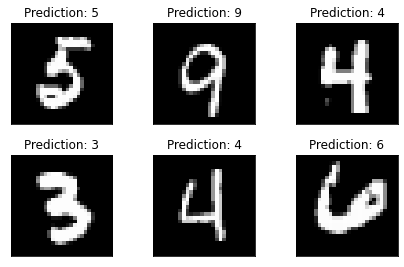

In [60]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig